# Chapter 5 Support Vector Machines


## Linear SVM Classification

Imagine you have linearly separable data separated into two classes. There are many possible decision boundaries which would correctly separate the data, but some would be better choices than others. For example, a decision boundary which is as close to an instance of one class and as far away as possible from the closest instance of the other class would do poorly when classifying new data points. An SVM classifier attempts to pick the boundary which creates the largest distance between the instances on the "edges" of both classes. This method is called large margin classification and these deciding instances are called support vectors. The area between the support vectors will be called the street.

### Soft Margin Classification

The method of hard margin classification requires that all instances be off the street and in the correct class. However, this method is only applicable when the data are actually linearly separable and creates bad decision boundaries when we have outliers in our data. Soft margin classification allows for instances to be misclassified and live within the street, which creates better performing decision boundaries. There is thus a tradeoff between the width of the street and the number of margin violations (either misclassified instances or instances in the street). The hyperparameter C controls both of these factors. Reducing C makes the margin less influenced by outliers and non-representative instances (we can remember it as the "c"ost of misclassification), and so acts as a form of regularization.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
# Petal length and width
X = iris['data'][:, (2,3)]
# Binary class (positive class is virginica)
y = (iris['target'] == 2).astype(np.float64)

svm_clf = Pipeline([
    # SVMs are sensitive to scaling!
    ('scaler', StandardScaler()),
    ('linear_svc', LinearSVC(C=1, loss='hinge'))
])

svm_clf.fit(X, y)
svm_clf.predict([[5.5, 1.7]])

array([1.])

We could also use stochastic gradient descent to train the classifier using SGDClassifier.

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X, y)
sgd_clf.predict([[5.5, 1.7]])

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


array([1.])

## Nonlinear SVM Classification

### Kernels

If we have nonlinear data, we can use the kernel method to transform the data into a higher-dimensional space to make it linearly separable. Let's look at polynomial kernels and Gaussian RBF Kernels. 

#### Polynomial Kernels

Polynomial kernels, as their name implies, emulate adding polynomial features to your dataset.

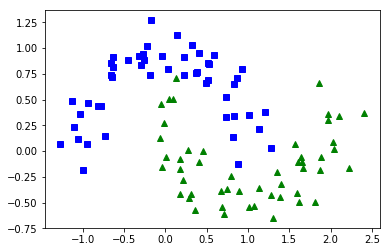

In [11]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^");

In [12]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    # coef0 controls relative degree of influence of high degree polynomials
    ('svm_clf', SVC(kernel='poly', degree=3, coef0=1, C=5))
])
poly_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=5, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

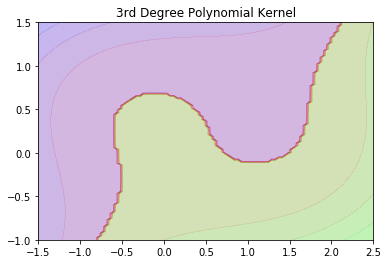

In [14]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
#plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title('3rd Degree Polynomial Kernel');

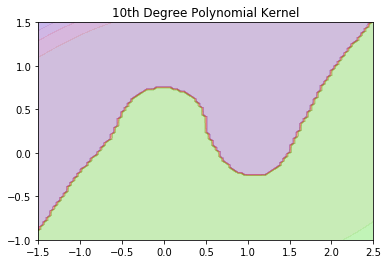

In [15]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    # coef0 controls relative degree of influence of high degree polynomials
    ('svm_clf', SVC(kernel='poly', degree=10, coef0=1, C=5))
])
poly_kernel_svm_clf.fit(X, y)

plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
#plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title('10th Degree Polynomial Kernel');

We can see that a higher degree polynomial is more prone to overfitting, since the decision boundary is much closer to one class than it is to the other.

#### Gaussian RBF Kernels

Let's also look at Gaussian radial basis functions. These functions represent distance from a "landmark" and range from 0 to 1. It takes a value of 1 if the feature is at the landmark, and approaches 0 symmetrically the further away the feature gets (shaped like a normal distribution). The hyperparameter gamma is inversely correlated with the width of this function (the variance of the distribution). A smaller gamma, or higher variance, has the effect of increasing the influence of each landmark and thus smooths out the decision boundary. 

The Gaussian RBF kernel has the equivalent effect of adding the output of these radial basis functions as features, with the actual data points acting as landmarks. Let's visualize the effect of different parameters for this type of kernel.

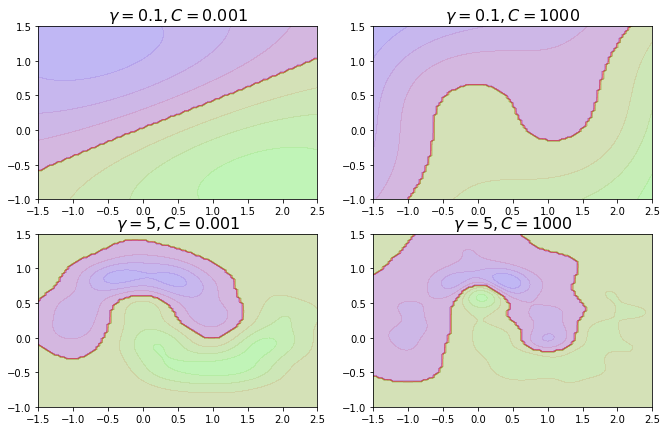

In [17]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

plt.figure(figsize=(11, 7))

for i, svm_clf in enumerate(svm_clfs):
    plt.subplot(221 + i)
    plot_predictions(svm_clf, [-1.5, 2.5, -1, 1.5])
    #plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)

## SVM Regression

Regression work support vector machines work similarly as it does for classification, but instead of trying to keep instances off the street, SVM regression tries to fit instances on the street, and margin violations are now considered instances off the street. The width of the street is controlled by the hyperparameter epsilon (a larger epsilon means a wider street).

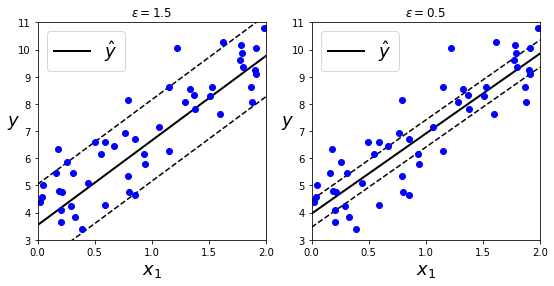

In [18]:
# Linear regresion
from sklearn.svm import LinearSVR

m = 50 # number of instances
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r'$ y $', fontsize=18, rotation=0)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon));
plt.subplot(122)
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon));

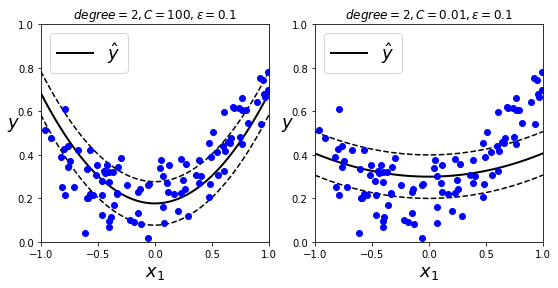

In [19]:
# Non-linear regression
from sklearn.svm import SVR

m = 100 # number of instances
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

# Qaudratic polynomial kernels
svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="auto")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="auto")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon))
plt.subplot(122)
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon));